**Econ691-06 | Hanh Nong**
# <center>ASSIGNMENT 6</center>

In [1]:
#setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sfa
from statsmodels.iolib.summary2 import summary_col
from scipy import stats
import seaborn as sns
from scipy.stats import norm
from sklearn.linear_model import Ridge, Lasso
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

AV Club, an online publisher known for its review of television shows and movies, is debating between two possible headlines for a short article. Those two headlines are:<br>
• Why the last episode of The Simpsons left us with a cliffhanger<br>
• What the cliffhanger means for the next episode of The Simpsons<br>
In both cases, the articles are the same (reviewing the last episode and forecasting the next episode); but the headline can either advertise its commentary on the last episode or on the next one. For the sake of notation, suppose the test is the first headline (the last episode) and the control is the second headline (the next episode). AV Club wants to deploy a bandit to maximize time spent reading the article.

The response functions for article readers is below, in both Python and R. These represent the amount of time, in seconds, that readers spend reading the article. Notice that the response function differ from the one discussed in class in one crucial dimension: the response to treatment changes over time. Early readers have a relatively positive reaction to the first headline compared to the second one, while later readers have a relatively negative reaction. This should not be
surprising, given that the first headline focuses on the last episode and so does best right after the episode has been aired; and the second headline focuses on the next episode and so does best right before that episode is to be aired. In this simulation, we will always assume there are five hundred readers who come to the article, so i ranges from 1 to 500.

In [2]:
def individual_response(treatment, i):
    return(max(0, 12 + (5 - i/70) * treatment + np.random.normal(0, 5, 1)[0]))

## 1. (5 points)
In class, we covered three approaches: the standard experiment (in which each user is independently assigned to treatment with 50% probability), the constant - $\epsilon$ bandit, and the declining - $\epsilon$ bandit. Include them in your code, and update them in two ways. First, update both their default n and their calls to the individual response function. Second, have the functions only return the average time-spent, in seconds, on the article. This is because the coefficient and standard error are no longer useful attributes of the data, because of the variation in the coefficient across time and across the order of units.<br>
• Note that you may wish to partially or fully consolidate these functions to make them more readable. In the solutions, for instance, I will consolidate all three approaches and the following approach (Thompson sampling) into a single function. This is encouraged but not required for full credit.

In [3]:
#Set up output function
def output_print(method, response_mean, indicator_sum):
    print("---------------------------------------------------------------------")
    print(str(method.capitalize())+" approach:")
    print("\tThe time spent on the site, per person, is: " + 
    str(round(response_mean, 4)) + " seconds.")
    print("\tThere were " + str(round(indicator_sum)) + " treated obs.")    

In [23]:
# Define the function that implements different approaches
def experiment_tools(n = 500, param = 0, method = '', output = False):
    #method takes values 'experiment', 'constant', 'declining', 'thompson'
    #param: input epsilon for constant, alpha for declining, burn-in for Thompson
    response = np.array([])
    indicator = np.array([])
    p_thompson = np.array([])

    for i in range(n):
        # Implement 'explore' phase
        explore_cond = np.random.rand(1)[0] if (method == 'constant' or method == 'declining') else i
        explore_threshold = n
        if method != 'experiment':
            explore_threshold = np.exp(-param * i) if method == 'declining' else param
                
        if explore_cond < explore_threshold:
            treatment = 1 if np.random.rand(1)[0] < 0.5 else 0

        # Else implement 'exploit' phase, where we take the best arm (greedy)
        else:
            # Identify the best arm, add 0.001 to avoid division-by-zero issues
            s1, n1 = response[indicator == 1], sum(indicator)
            s2, n2 = response[indicator == 0], i - n1
            y1, y2 = sum(s1)/(n1 + 0.001), sum(s2)/(n2 + 0.001)
            
            if method == 'thompson': 
                exploit_cond = np.random.rand(1)[0]
                exploit_threshold = 1 - stats.ttest_ind(s1, s2, equal_var=False)[1]/2                
                p_thompson = np.append(p_thompson, exploit_threshold)
            
            else:
                exploit_cond = y2 - y1
                exploit_threshold = 0

            treatment = 1 if exploit_cond < exploit_threshold else 0

        # Get and save the individual's response
        response = np.append(response, individual_response(treatment, i))
        indicator = np.append(indicator, treatment)
 
    if output == True:
        output_print(method, sum(response)/n, sum(indicator))

    return response, indicator, p_thompson

In [9]:
np.random.seed(10)
experiment = experiment_tools(method = 'experiment', output = True)
constant = experiment_tools(param = 0.1, method = 'constant', output = True)
declining = experiment_tools(param = 0.001, method = 'declining', output = True)
thompson = experiment_tools(param = 30, method = 'thompson', output = True)

---------------------------------------------------------------------
Experiment approach:
	The time spent on the site, per person, is: 12.8728 seconds.
	There were 265.0 treated obs.
---------------------------------------------------------------------
Constant approach:
	The time spent on the site, per person, is: 13.2437 seconds.
	There were 461.0 treated obs.
---------------------------------------------------------------------
Declining approach:
	The time spent on the site, per person, is: 12.9399 seconds.
	There were 301.0 treated obs.
---------------------------------------------------------------------
Thompson approach:
	The time spent on the site, per person, is: 12.6398 seconds.
	There were 475.0 treated obs.


## 2. (25 points) ***(Answered in Question 1)***
AV Club also wants to implement a bandit that utilizes Thompson sampling, and asks for your assistance. Implement one, using the hints and guidance below; and demonstrate that it works by running the function once.<br>
• While Thompson sampling does not technically need a phase with uniform random sampling (as the other bandit algorithms do), most Thompson sampling algorithms use a “burn-in” period with uniform random sampling for the first few observations. As such, allow the algorithm to explore randomly between test and control for the first thirty observations.<br>
• Once this burn-in period has elapsed, sample each arm with the probability that it is the better arm. As a hint to calculate this probability, recall the following formula for the two-sample t-test; and consider how it may apply in this case.

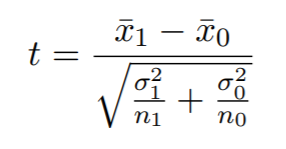


## 3. (10 points)
***Evaluate the constant - $\epsilon$ algorithm under four parameterizations:  $\epsilon$ = 0.5, $\epsilon$ = 0.3, $\epsilon$ = 0.1, and $\epsilon$ = 0.01. To mitigate noise, run each parameterization on one hundred different streams of data, and take the average of the hundred runs per parameterization. Explain the results: which $\epsilon$ performs best, which $\epsilon$ performs worst, and why?***

Since the outcomes change with later readers, the best arm in earlier exploration units will change in later exploration units. 

$\epsilon = 0.1$ performs best. As $\epsilon$ gets larger, we have more observations to identify the best arm in exploration phase but at the same time, we have less observations to send to the better arm in exploitation phase. With this $\epsilon$, we only sent observation to exploration 10% of times. In this scenario, 10% may be good enough to learn about the best arm, and hence, we have more remaining observations to send to the best arm. Since we keep this 10% rate constant throughout the bandit, we can capture the change in best arm in the later stage of exploration and can reflect this in our exploitation phase.

$\epsilon = 0.01$ performs worst. We have plenty of observations for exploitation but we perform exploration on very limited data as we only send observations to exploration 1% of times. This is not enough to learn about the best arm. Assuming the environment doesn't change, as time goes by, we may have better idea of which one is the best arm. But since we are not well-informed of the best arm from previous observations, by the time the exploration result becomes reliable, we already sent too many observations to the worse arm and we can't come back to correct our mistakes anymore. In this scenario, the best arm may change sometimes after the episode aired. That makes our result from exploration on very limited data becomes even worse as the accumulated results it gathered from previous observations are no longer meaningful.

In [10]:
#This function is used for Question 3, 4, & 5
def optimal_params(iteration_num, n, param_name, param_list, method, plot = False):
    resp_optimal, treated_obs_optimal = [], []
    treated_obs = []
    for p in param_list:
        resp_i, treated_obs_i = [], []
        for i in range(iteration_num):
            result = experiment_tools(param = p, method = method)
            #collect response and number of treated obs of each iteration
            resp_i.append(sum(result[0]/n))
            treated_obs_i.append(sum(result[1]))
            treated_obs.append(result[1])
        #collect mean response and mean of treated obs of all iterations for each param
        resp_optimal.append(np.mean(resp_i)) 
        treated_obs_optimal.append(np.mean(treated_obs_i))
    
    if plot == True:
        plt.figure(figsize = (10,5))
        plt.grid(color='0.9')
        plt.title("Average time spent per person by "+
                  str(param_name)+" for "+str(method)+" approach")
        plt.plot(param_list, resp_optimal)
        plt.xticks(param_list)
        plt.yticks(resp_optimal)
        plt.xlabel(str(param_name))
        plt.ylabel("Average time spent");
    return resp_optimal, treated_obs_optimal, treated_obs

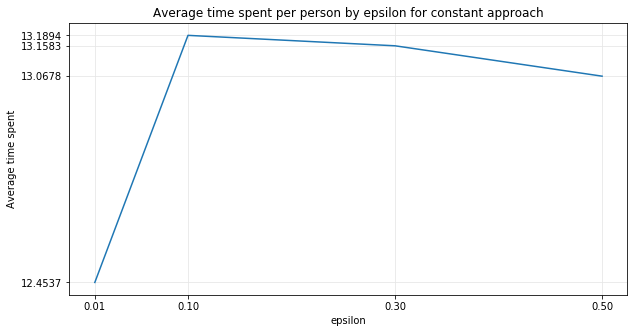

In [11]:
np.random.seed(10)
Epsilon = [0.5, 0.3, 0.1, 0.01]
resp_constant = optimal_params(iteration_num = 100, n = 500, 
               param_name = 'epsilon', param_list = Epsilon, 
               method = 'constant', plot = True)

In [19]:
print("The highest timespent is "+str(round(np.max(resp_constant[0]),4))+
      ", using epsilon of "+str(round(Epsilon[np.argmax(resp_constant[0])],4)))
print("The lowest timespent is "+str(round(np.min(resp_constant[0]),4))+
      ", using epsilon of "+str(round(Epsilon[np.argmin(resp_constant[0])],4)))

The highest timespent is 13.1894, using epsilon of 0.1
The lowest timespent is 12.4537, using epsilon of 0.01


## 4. (10 points)
***Evaluate the declining - $\epsilon$ algorithm under three parameterizations: α = 0.01, α = 0.005, and α = 0.001. To mitigate noise, run each parameterization on one hundred different streams of data, and take the average of the hundred runs per parameterization. <br>
Explain the results: which α performs best, which α performs worst, and why?***

$\alpha = 0.01$ performs best. A larger alpha means we start exploration with fewer observations. However, as alpha gets larger, the declining rate in exploration also gets larger. Hence, as long as we don't start exploration with too small number of observations, we can have a good idea of which arm is better before the the declining rate shrinks the pool of observations for exploration. Thus, we can quickly send more observations to the better arm as the declining rate increases, and in this case, before the environment change. As the environment changes, we also send fewer observations to exploration and more to exploitation. Our estimate of the better arm may not be as good as before, but in exchange, we already successfully capture the best arm before it changes.

$\alpha = 0.001$ performs worst. We start with large amount of observations for exploration, we should expect that we have a very good idea of which arm is better. However, since the declining rate is too slow, we fail in sending more observations to that better arm and we end up having more observations in the worse arm.

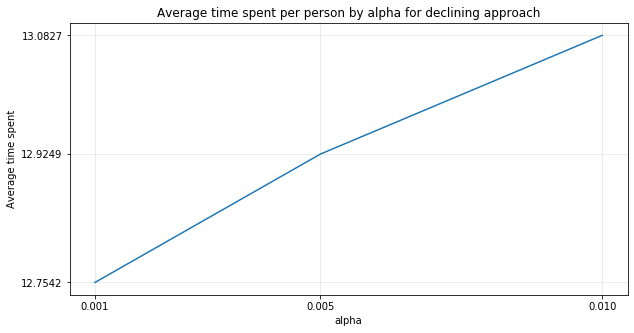

In [12]:
np.random.seed(10)
Alpha = [0.01, 0.005, 0.001]
resp_declining = optimal_params(iteration_num = 100, n = 500, 
               param_name = 'alpha', param_list = Alpha, 
               method = 'declining', plot = True)

In [21]:
print("The highest timespent is "+str(round(np.max(resp_declining[0]),4))+
      ", using alpha of "+str(round(Alpha[np.argmax(resp_declining[0])],4)))
print("The lowest timespent is "+str(round(np.min(resp_declining[0]),4))+
      ", using alpha of "+str(round(Alpha[np.argmin(resp_declining[0])],4)))

The highest timespent is 13.0827, using alpha of 0.01
The lowest timespent is 12.7542, using alpha of 0.001


## 5. (5 points)
***Evaluate the four approaches: the experiment, the best constant - $\epsilon$ algorithm, the best declining - $\epsilon$ algorithm, and Thompson sampling. To mitigate noise, run each algorithm on one hundred different streams of data, and take the average of the hundred runs per algorithm.***

The Thompson approach performs best and the experiment approach performs worst. The constant approach performs better than the declining approach. Experiment approach sent around half of the observations to treatment, while the constant, declining and Thompson approaches sent around 90% of observations to the treatment.

In [13]:
np.random.seed(10)
approach = ['experiment', 'constant', 'declining', 'thompson']
best_params = [[0], [Epsilon[np.argmax(resp_constant[0])]], 
               [Alpha[np.argmax(resp_declining[0])]], [30]]
resp = np.array([])
treated_obs = np.array([])
treated_obs_all = np.array([])
print("Average time spent per person with 100 iterations")
for i in range(4):
    result = optimal_params(iteration_num = 100, n = 500, 
                   param_name = '', param_list = best_params[i], 
                   method = approach[i], plot = False)
    resp = np.append(resp, result[0])
    treated_obs = np.append(treated_obs, result[1])
    treated_obs_all = np.append(treated_obs_all, result[2])
    output_print(approach[i], result[0][0], result[1][0])

Average time spent per person with 100 iterations
---------------------------------------------------------------------
Experiment approach:
	The time spent on the site, per person, is: 12.7172 seconds.
	There were 250.0 treated obs.
---------------------------------------------------------------------
Constant approach:
	The time spent on the site, per person, is: 13.1524 seconds.
	There were 444.0 treated obs.
---------------------------------------------------------------------
Declining approach:
	The time spent on the site, per person, is: 13.0906 seconds.
	There were 449.0 treated obs.
---------------------------------------------------------------------
Thompson approach:
	The time spent on the site, per person, is: 13.298 seconds.
	There were 471.0 treated obs.


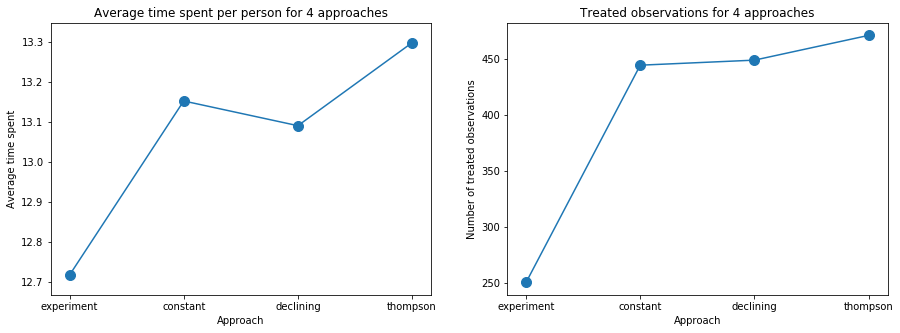

In [14]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].set_title("Average time spent per person for 4 approaches")
ax[0].scatter(approach, resp, s = 100)
ax[0].plot(approach, resp)
ax[0].set_xlabel("Approach")
ax[0].set_ylabel("Average time spent");

ax[1].set_title("Treated observations for 4 approaches")
ax[1].scatter(approach, treated_obs, s = 100)
ax[1].plot(approach, treated_obs)
ax[1].set_xlabel("Approach")
ax[1].set_ylabel("Number of treated observations");

## 6. 
***Using these results, answer the following questions comparing Thompson sampling to each of the algorithms in turn.***

By design, the response for 2nd headline does not change much but the decline in response for 1st headline is much more obvious. 1st headline has more positive response than 2nd one but at a certain time, it would become less positive than the 2nd one (the right graph below). A better approach can detect the cut-off point earlier and adjust its exploitation accordingly. The left graph below shows how earlier each approach (except experiment) slow down in sending observations to treatment group.

In [15]:
ir_1 = []
ir_0 = []
for i in range(500):
    ir_1.append(individual_response(1,i))
    ir_0.append(individual_response(0,i))

treated_obs_split = np.split(treated_obs_all, 4)

t_obs_exp = np.mean(np.cumsum(np.split(treated_obs_split[0], 100), axis = 1), axis = 0)
t_obs_constant = np.mean(np.cumsum(np.split(treated_obs_split[1], 100), axis = 1), axis = 0)
t_obs_declining = np.mean(np.cumsum(np.split(treated_obs_split[2], 100), axis = 1), axis = 0)
t_obs_thompson = np.mean(np.cumsum(np.split(treated_obs_split[3], 100), axis = 1), axis = 0)

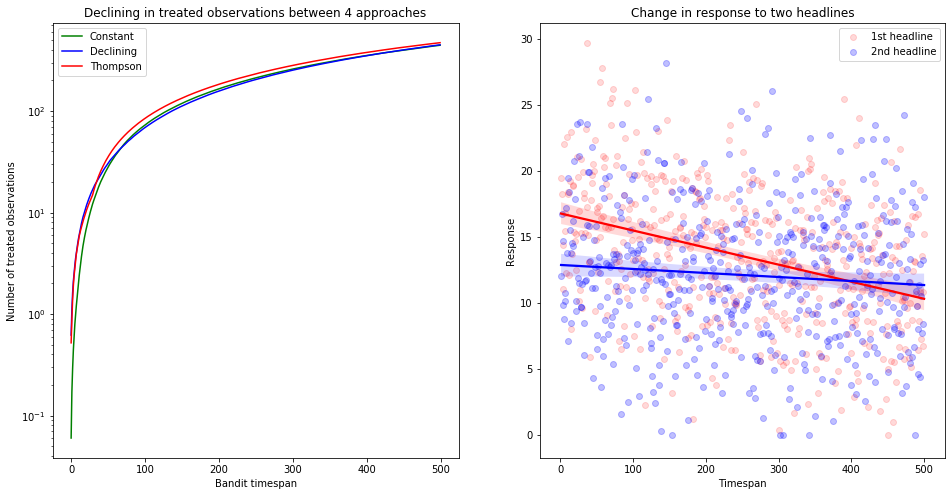

In [16]:
f, ax = plt.subplots(1,2,figsize = (16,8))
ax[0].set_title("Declining in treated observations between 4 approaches")
ax[0].semilogy(t_obs_constant, label = 'Constant', color = 'green')
ax[0].semilogy(t_obs_declining, label = 'Declining', color = 'blue')
ax[0].semilogy(t_obs_thompson, label = 'Thompson', color = 'r')
ax[0].set_xlabel("Bandit timespan")
ax[0].set_ylabel("Number of treated observations")
ax[0].legend()

ax[1].set_title("Change in response to two headlines")
sns.regplot(x=np.arange(1,501), y=ir_1, truncate = True,
            scatter_kws={"alpha": 0.15}, 
            color = 'r', label = "1st headline", ax = ax[1])
sns.regplot(x=np.arange(1,501), y=ir_0, truncate = True,
            scatter_kws={"alpha": 0.25}, 
            color = 'blue', label = "2nd headline", ax = ax[1])
ax[1].set_xlabel("Timespan")
ax[1].set_ylabel("Response")
ax[1].legend();

### (a) (5 points) 
***Compare Thompson sampling to the experiment. Which performs better and why?***

Thompson performes better than experiment. <br>As it explores and exploits at the same time and updates the proportion of treatment units along the way, it ends up having much more units in better arm than experiment. Experiment approach uses the fixed ratio of treatment and control and cannot go back to update this ratio. In this case, the environment changes from the first headline to the second headline. Thompson can capture this change and reflect this in its exploitation phase while a standard experiment cannot do that.

### (b) (5 points) 
***Compare Thompson sampling to the best constant - $\epsilon$ algorithm. Which performs better and why?***

Thompson performs better than the best constant epsilon algorithm. <br>Constant does not update the probability of sending an observation to exploitation as quickly as Thompson. As the change in environment is gradual and as the exploration is only on a small subset of observations, it may take constant approach a while to sucessfully recognize the change. In contrast, Thompson constantly update the probability of treatment being better on every observation and make change to the exploitation phase as soon as the flip in outcomes starts to become clear. <br>Both Thompson and constant approaches converge to relative same number of treated observations. However, the graph above shows Thompson approach is quicker in reducing the number of observation to be sent to treatment group compared to constant. 

### (c) (5 points) 
***Compare Thompson sampling to the best declining - $\epsilon$ algorithm. Which performs better and why?***

Thompson performs better than the best declining epsilon algorithm. <br>The best declining epsilon algorithm probably does better than Thompson in the earlier stage of bandit. However, as the exploration pool declines, its ability to capture the downward trend in first headline also declines. In addition, it sends more observation to the predicted better arm in the later stage of bandit. Thompson may not be very successful during first observations but it performs better in the long run when the environment changes due to its ability to update timely the gradual shift from first headline to the second headline. <br>Both Thompson and declining approaches converge to relative same number of treated observations. However, Thompson approach curve's slope in the above graph is flatter than declining approach curve at around the 50th observation, meaning Thompson sent observations to treatment with decreasing rate earlier than declining approach.